# Make Recommendation

In [1]:

from sqlalchemy.orm import sessionmaker
from models import connect_db, PointsOfInterest, ArchitecturalStyles, Architects,POICategories
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance
import geocoder
import os
from dotenv import load_dotenv, find_dotenv
import time
import seaborn as sns
import numpy as np
import folium
from folium.features import DivIcon

DEBUG=0

In [2]:
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from copy import copy

In [3]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import googlemaps
import os
#from sqlalchemy import create_engine
from dotenv import load_dotenv, find_dotenv
import math
import pickle

In [4]:
def make_session():
    db=connect_db() #establish connection / creates database on first run
    Session = sessionmaker(bind=db)
    session = Session()
    return db, session

In [5]:
def make_simple_poi(org_type):
    if org_type == 'Plaque':
        return org_type
    elif org_type == 'Monument':
        return 'Art'
    else:
        return 'Building'


In [6]:
def add_features(df):
    df['cleaned_year']=df['build_year'].apply(lambda x: clean_build_year(x))
    df['cleaned_year']=pd.to_numeric(df['cleaned_year'],errors='coerce',downcast='integer')
    df['build_decade']= df['cleaned_year'].apply(lambda x: x//10*10 )
    df['poi_type_simple'] = df['poi_type'].apply(lambda x: make_simple_poi(x))
    return df

In [7]:
def clean_build_year(year):
    if year == None or len(year) < 4:
        return ''
    strip_words = ['unknown', 'circa ', 'abt ', 'about']
    for word in strip_words:
        year=year.replace(word, '')
    return year[0:4]

In [8]:
def get_pois_as_df():
    
    db, session = make_session()
    sql='''SELECT poi.*, styl.style, pcat.category
    FROM points_of_interest poi
    LEFT JOIN architectural_styles styl on (styl.poi_id = poi.poi_id)
    LEFT JOIN poi_categories pcat on (pcat.poi_id = poi.poi_id)
    order by poi.poi_id
    '''
    df = pd.read_sql_query(sql, db)
    df= add_features(df)
    return df

In [9]:
poi_mapper = DataFrameMapper([
   #('Date',None),
    # drop block and address
   # (['poi_id'], None),
    ('build_decade',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('category',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     #('architect_name',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('style',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
     ('poi_type_simple',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
    # ('current_use',[CategoricalImputer(replacement="n/a"), LabelBinarizer()]),
  #  (['latitude'],None),
  #  (['longitude'],None)
], df_out=True)

In [10]:
def get_user_profile(profile_num):
    '''
    # USER PROFILE 1 - interested in People (plaques), Entrepreneurs (32) Medicine (44), Science and Technology (52), Women (56), Sports(53) and modern buildings
    # USER PROFILE 2 -- interested in People (plaques 104) Explorers (33), Pioneers (46), Cemeteries (25), First Nations(35)
# and early buildings (0-9)
    # USER PROFILE 3 -- interested in Art ()
    '''
    user_prefs = np.zeros(105)
    if profile_num== 1:
        for i in [32, 52, 44, 56,53, 67,70,75,77, 79, 80, 83, 89, 104]:
            user_prefs[i] = 1
    elif profile_num==2:
        for i in [0,1,2,3,4,5,6,7,8,9,25, 33,35, 46,104]:
            user_prefs[i] = 1
    else:
        for i in [102]:
            user_prefs[i] = 1
    df_user=pd.DataFrame(user_prefs).T#, columns=df_features.columns)
#     df_user.columns = df_features.columns
#     #df_user=pd.DataFrame.from_records(user_prefs,)
#     df_user.head()
    return df_user

In [11]:

def find_similarity(df_features, df_user,  df_poi, sim_method=cosine_similarity):

    if sim_method ==cosine_similarity:
        cosine_sim = cosine_similarity(df_features,df_user)
        user_matches = pd.DataFrame(cosine_sim, columns=['user_match'])
        user_matches.sort_values('user_match', ascending=False, inplace=True)
        df_poi['sim_rating'] = 0
        for ix,row in user_matches.iloc[0:20,:].iterrows():
          #  print(ix, row)
            # now find matches close to target of interest - ix is row in dataframe that matches to user match
            df_poi.loc[ix,'sim_rating'] = row.user_match
        df_poi.sort_values('sim_rating', inplace=True, ascending=False)
#     else:
#         np_features = df_poi.as_matrix()
#         site_prefs=[]
#         for i in range(0,len(np_features)):
#             np_features[i,:]
#             result = spatial.distance.cosine(np_features[i,:], U)#, weight_of_importance)
#             res_dict = {'ix': i, 'dist': result}
#             site_prefs.append(res_dict)
#         df_site_prefs = pd.DataFrame(site_prefs)
#         df_site_prefs.sort_values('dist', inplace=True)
#         df_site_prefs.head()
#         #user_matches.iloc[0:20,:]
#         for ix,row in df_site_prefs.iloc[0:20,:].iterrows():
#             # now find matches close to target of interest
#             print(df.iloc[ix,1])


    return df_poi


In [12]:
def find_points_in_area(df, lat, long, num_points, max_distance):
    
    avail_points = []
    found_points =0
    prev_coord = (0,0) # sometimes have two points at same lat/long -- don't count as an extra stop
    
    for ix, row in df.iterrows():

        curr_pt = geopy.distance.geodesic((row['latitude'], row['longitude']), (lat, long)).meters
       # print(curr_pt)
        
        if curr_pt<= max_distance:
           # print(row['latitude'], row['longitude'], curr_pt)
            my_dict={}
            my_dict =row.to_dict()
            my_dict['dist_start'] = curr_pt
            avail_points.append(my_dict)
            if (row['latitude'], row['longitude']) !=prev_coord:
                found_points +=1
            prev_coord = (row['latitude'], row['longitude'])
            if found_points > num_points:
                break
    df_2 = pd.DataFrame(avail_points)
    return df_2

In [13]:
#initialize map with a default lat and long
import folium
def plot_stops(starting_lat, starting_long, df):
    map_clusters = folium.Map(location=[43.67146, -79.37515], zoom_start=11)
    folium.CircleMarker(
        [starting_lat, starting_long],
        radius=5,
        color='red',
         fill=True,
           fill_color='#3186cc',
           fill_opacity=0.7).add_to(map_clusters)



    # loop through dataframe
    for lat, lng, name, address in zip(df['latitude'], df['longitude'],  df['name'],df['address']):
       label = '{} {}'.format(name, address)
       label = folium.Popup(label, parse_html=True)
       folium.CircleMarker(
           [lat, lng],
           radius=5,
           popup=label,
           color='blue',
           fill=True,
           fill_color='#3186cc',
           fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

### Test from a point

In [14]:
# # king/simco
# starting_lat =43.647273
# starting_long=-79.386560

# walk_duration = 1 # in hours
# num_points = 12
# max_distance = 1000 # meters
# num_pois_visit = 20

In [15]:
# df_user = get_user_profile(3)
# df_poi = get_pois_as_df()
# df_features=df_poi.copy()
# poi_mapper.fit(df_features)
# df_features= poi_mapper.transform(df_features)
# df_poi=find_similarity(df_features, df_user, df_poi)
# df_filtered = find_points_in_area(df_poi, starting_lat, starting_long, num_points, max_distance)
# #plot_stops(starting_lat, starting_long, df_filtered)

In [16]:
# map_stops = plot_stops(starting_lat, starting_long, df_filtered)
# map_stops

# GENETIC ALGORITHM TO PLOT POINTS
* borrowed and slightly adapted from https://github.com/ZWMiller/PythonProjects/blob/master/genetic_algorithms/evolutionary_algorithm_traveling_salesman.ipynb

In [17]:
# TODO: cluster points

In [18]:
def get_dict_of_stop_coords(df,starting_lat, starting_long, key_to_use='poi_id'):
    '''
    create dictionary of stops with lat/long coords
    first stop is the starting point
    '''
   # print(f'starting point ({starting_lat}, {starting_long})')
    walk_stops = {}
    walk_stops[0] = (starting_lat, starting_long)
    for ix,row in df_filtered.iterrows():
        
        if key_to_use=='poi_id':
            walk_stops[row['poi_id']] = (row['latitude'], row['longitude'])
        else:
            walk_stops[ix+1] = (row['latitude'], row['longitude'])
        
    return walk_stops

In [19]:

def create_guess(walk_stops):
    """
    Creates a possible path between all cities, returning to the original.
    Point 0 is our starting point and must stay as our starting point
    Input: List of City IDs
    """
    guess = copy(walk_stops)
   # print(f"before shuffle {guess}")
    start = guess.pop(0)# save our starting point and remove from dict
    np.random.shuffle(guess)
   # print(f"after shuffle {guess}")
   # guess[0] = start
    guess.insert(0,start)
    #guess.append(guess[0])
    return list(guess)

#print(create_guess(list(walk_stops.keys())))


In [20]:

def create_generation(points, population=100):
    """
    Makes a list of guessed point orders given a list of point IDs.
    Input:
    points: list of point ids
    population: how many guesses to make
    """
    generation = [create_guess(points) for _ in range(population)]
    return generation

# test_generation = create_generation(list(walk_stops.keys()), population=10)
# for gen in test_generation:
#     print(gen)

In [21]:
def travel_time_between_points(point_1, point_2):
    '''
    pass in coords for 2 points
    calculate distance between them in meters and then estimate walking time
    '''
    # typical walkign speed is 1.4m/sec
    speed = 1.4
    #find dist between 2 points
    dist = geopy.distance.geodesic(point_1, point_2).meters
    # return guess speed in seconds
    return dist/speed

In [22]:
def fitness_score(guess, walk_stops):
    """
    Loops through the points in the guesses order and calculates
    how much distance the path would take to complete a loop.
    Lower is better.
    """
    score = 0
    for ix, point_id in enumerate(guess[:-1]):
        score += travel_time_between_points(walk_stops[point_id], walk_stops[guess[ix+1]])
    return score

def check_fitness(guesses, walk_stops):
    """
    Goes through every guess and calculates the fitness score. 
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess, walk_stops)))
    return fitness_indicator

#print(check_fitness(test_generation))

In [23]:
def get_breeders_from_generation(guesses, walk_stops, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses, walk_stops)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]] # takes top 5
    best_guess = new_generation[0] # best guess is the best score
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        ix = np.random.randint(len(guesses))
        new_generation.append(guesses[ix])
        
    # No mutations here since the order really matters.
    # If we wanted to, we could add a "swapping" mutation,
    # but in practice it doesn't seem to be necessary
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """ 
    Take some values from parent 1 and hold them in place, then merge in values
    from parent2, filling in from left to right with cities that aren't already in 
    the child. 
    """
    list_of_ids_for_parent1 = list(np.random.choice(parent1, replace=False, size=len(parent1)//2))
   # print(list_of_ids_for_parent1)
    child = [-99 for _ in parent1] # fill with placeholders so now all -99 values can be replaced with genes from parent 2
    
    for ix in range(0, len(list_of_ids_for_parent1)):
        child[ix] = parent1[ix]

    for ix, gene in enumerate(child):
 
        if gene == -99:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    #child[-1] = child[0]
    return child

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    If there are an odd number of parent possibilities, one 
    will be left out. 
    
    Pairing happens by pairing the first and last entries. 
    Then the second and second from last, and so on.
    """
  #  print(old_generation)
    mid_point = len(old_generation)//2
#    print(mid_point)
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
   # print(next_generation)
    return next_generation

In [24]:
def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, walk_stops, verbose=False):
    """
    Takes in a generation of guesses then evolves them over time using our breeding rules.
    Continue this for "max_generations" times.
    Inputs:
    current_generation: The first generation of guesses
    max_generations: how many generations to complete
    take_best_N: how many of the top performers get selected to breed
    take_random_N: how many random guesses get brought in to keep genetic diversity
    mutation_rate: How often to mutate (currently unused)
    children_per_couple: how many children per breeding pair
    print_every_n_geneartions: how often to print in verbose mode
    verbose: Show printouts of progress
    Returns:
    fitness_tracking: a list of the fitness score at each generations
    best_guess: the best_guess at the end of evolution
    """
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation, walk_stops, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess, walk_stops))
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    
    return fitness_tracking, best_guess

#current_generation = create_generation(list(walk_stops.keys()),population=500)
# for gen in current_generation:
#     print(gen)

In [25]:
def add_stop_order_to_df(df, order_guess, key_to_use='poi_id'):
    df['order'] =0
    cnt = 1
    for ix in order_guess[1:]:
        if key_to_use=='poi_id':
            index = df[df_filtered['poi_id'] ==ix].index
        else:
            index = ix-1
#             df_filtered.iloc[12,1]
#             index = df[df_filtered['poi_id'] ==ix].index
        df.iloc[index,-1]=cnt
        cnt +=1
    return df

In [26]:
def plot_guess(city_coordinates, guess, guess_in_title=True):
    """
    Takes the coordinates of the cities and the guessed path and
    makes a plot connecting the cities in the guessed order
    Input:
    city_coordinate: dictionary of city id, (x,y)
    guess: list of ids in order
    """
    plot_cities(city_coordinates, guess=guess)
    for ix, current_city in enumerate(guess[:-1]):
        x = [city_coordinates[guess[ix]][0],city_coordinates[guess[ix+1]][0]]
        y = [city_coordinates[guess[ix]][1],city_coordinates[guess[ix+1]][1]]
        plt.plot(x,y,'c--',lw=1)
    plt.scatter(city_coordinates[guess[0]][0],city_coordinates[guess[0]][1], marker='x', c='b')   
    if guess_in_title:
        plt.title("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    else:
        print("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    


In [27]:
def plot_cities(city_coordinates, annotate=True, guess=None):
    """
    Makes a plot of all cities.
    Input: city_coordinates; dictionary of all cities and their coordinates in (x,y) format
    """
    names = []
    x = []
    y = []
    plt.figure(dpi=250, figsize=(20,20))
    for key in list(city_coordinates.keys()):
        names.append(key)
        x.append(city_coordinates[key][0])
        y.append(city_coordinates[key][1])
        if annotate:
            if guess:
                plt.annotate(guess.index(key), xy=(city_coordinates[key][0], city_coordinates[key][1]), xytext=(20, -20),
                            textcoords='offset points', ha='right', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
                            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
            else:
                plt.annotate(ix, xy=(city_coordinates[key][0], city_coordinates[key][1]), xytext=(20, -20),
                            textcoords='offset points', ha='right', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
                            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.scatter(x,y,c='r',marker='o')

In [28]:
def make_fitness_tracking_plot(fitness_tracking):
    """
    Given a list of fitness scores, plot it versus the generation number
    """
    plt.figure(dpi=150)
    plt.plot(range(len(fitness_tracking)), fitness_tracking)
    plt.ylabel("Fitness Score")
    plt.xlabel("Generation")
    plt.title("Fitness Evolution");

#make_fitness_tracking_plot(fitness_tracking)

In [29]:
def plot_stops_with_order(df):
    map_clusters = folium.Map(location=[43.67146, -79.37515], zoom_start=11)
    folium.CircleMarker(
        [starting_lat, starting_long],
        radius=5,
        color='red',
         fill=True,
           fill_color='#3186cc',
           fill_opacity=0.7).add_to(map_clusters)



    # loop through dataframe
    for lat, lng, name, address,order in zip(df['latitude'], df['longitude'],  df['name'],df['address'], df['order']):
        label = '{} {}'.format(name, address)
        label = folium.Popup(label, parse_html=True)
        folium.map.Marker(
        [lat, lng],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
           # html='<b><div style="color:red,font-size: 10pt">{}</div></b>'.format(order),
            html='<b><div style="color:red">{}</div></b>'.format(order),
            )
        ).add_to(map_clusters)

    return map_clusters

In [30]:
def find_optimal_route(df, starting_lat, starting_long, method='genetic'):
    '''
    Possible methods: genetic or google optimisation tools
    '''
    walk_stops = get_dict_of_stop_coords(df, starting_lat, starting_long)
    if method == 'genetic':
        current_generation = create_generation(list(walk_stops.keys()),population=500)
        fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, walk_stops, verbose=True)
        plot_guess(walk_stops, best_guess)
        # add order to df.
        df=add_stop_order_to_df(df, best_guess)
        make_fitness_tracking_plot(fitness_tracking)
        map_stops = plot_stops_with_order(df)
    else:
        #method='google'
        walk_stops = get_dict_of_stop_coords(df, starting_lat, starting_long, key_to_use='count')
        dist_matrix=make_dist_matrix(len(walk_stops))
        order_guess=create_routing_model(walk_stops,dist_matrix)

        df=add_stop_order_to_df(df, order_guess,key_to_use='count')
        map_stops = plot_stops_with_order(df)
    return map_stops

# Try with Google OR Tools

In [31]:
def get_google_key():
    load_dotenv(find_dotenv())
    # load environment variables
    SECRET_KEY = os.getenv("GOOGLE_KEY")
    gmaps = googlemaps.Client(key=SECRET_KEY)
    return gmaps

In [32]:
# Distance callback
def create_distance_callback(dist_matrix):
    # Create a callback to calculate distances between cities.

    def distance_callback(from_node, to_node):
        # return int(dist_matrix[from_node][to_node])
        #print(dist_matrix[from_node][to_node])
        return dist_matrix[from_node][to_node]


    return distance_callback

In [33]:
def make_dist_matrix(num_rows):
    #my_dist_matrix = np.zeros((len(walk_stops), len(walk_stops)))
    dist_matrix = np.zeros((num_rows,num_rows))
    return dist_matrix
#dist_matrix = gmaps.distance_matrix(walk_stops.values(),walk_stops.values())
#my_dist_matrix[0,0]

In [34]:
def euclid_distance(x1, y1, x2, y2):
    # Euclidean distance between points.
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [35]:
def create_distance_matrix(locations):
    # Create the distance matrix.
    gmaps = get_google_key()
    size = len(locations)
    dist_matrix = {}

    for from_node in locations.keys():
        dist_matrix[from_node] = {}
        for to_node in locations.keys():
            x1 = locations.get(from_node)[0]
            y1 = locations.get(from_node)[1]
            x2 = locations.get(to_node)[0]
            y2 = locations.get(to_node)[1]
            #print(x1,y1, x2, y2)
           # dist_matrix[from_node][to_node] = euclid_distance(x1, y1, x2, y2)
            dist_matrix[from_node][to_node]  = gmaps.distance_matrix((x1,y1), (x2,y2), mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
    return dist_matrix

In [36]:
#dist_matrix
#https://developers.google.com/optimization/routing/tsp
def create_routing_model(walk_stops, dist_matrix ):
    tsp_size = len(walk_stops)
    num_routes = 1
    depot = 0
    best_guess=[]

    # Create routing model
    if tsp_size > 0:
        routing = pywrapcp.RoutingModel(tsp_size, num_routes, depot)
        search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
        # Create the distance callback.
        dist_matrix=create_distance_matrix(walk_stops)
        dist_callback = create_distance_callback(dist_matrix)
        #print(dist_matrix)
        routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
        # Solve the problem.
        assignment = routing.SolveWithParameters(search_parameters)
        if assignment:
            # Solution distance.
            print ("Total distance: " + str(assignment.ObjectiveValue()) + " miles\n")
            # Display the solution.
            # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
            route_number = 0
            index = routing.Start(route_number) # Index of the variable for the starting node.
            route = ''
            while not routing.IsEnd(index):
                # Convert variable indices to node indices in the displayed route.
                print(routing.IndexToNode(index))
                best_guess.append(routing.IndexToNode(index))
                route += str(walk_stops[routing.IndexToNode(index)]) + ' -> '
                index = assignment.Value(routing.NextVar(index))
            route += str(walk_stops[routing.IndexToNode(index)])
            print ("Route:\n\n" + route)
        else:
            print( 'No solution found.')
    else:
        print ('Specify an instance greater than 0.')
    return best_guess

# Plot a route

In [37]:
# king/simco
starting_lat =43.647273
starting_long=-79.386560

walk_duration = 1 # in hours
num_points = 12
max_distance = 1000 # meters
num_pois_visit = 20

In [38]:
df_user = get_user_profile(3)
df_poi = get_pois_as_df()
df_features=df_poi.copy()
poi_mapper.fit(df_features)
df_features= poi_mapper.transform(df_features)
df_poi=find_similarity(df_features, df_user, df_poi)
df_filtered = find_points_in_area(df_poi, starting_lat, starting_long, num_points, max_distance)
#plot_stops(starting_lat, starting_long, df_filtered)

In [39]:
# map_stops = plot_stops(starting_lat, starting_long, df_filtered)
# map_stops

Generation 5: 330
Current Best Score:  3397.8100821363046
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 10: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 15: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 20: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 25: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 30: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 35: 330
Current Best Score:  3594.762648421639
[0, 317, 3113, 3112, 3111, 3103, 3110, 2959, 3076, 3078, 3077, 2944, 2945, 2947]
Generation 40: 330
Current 

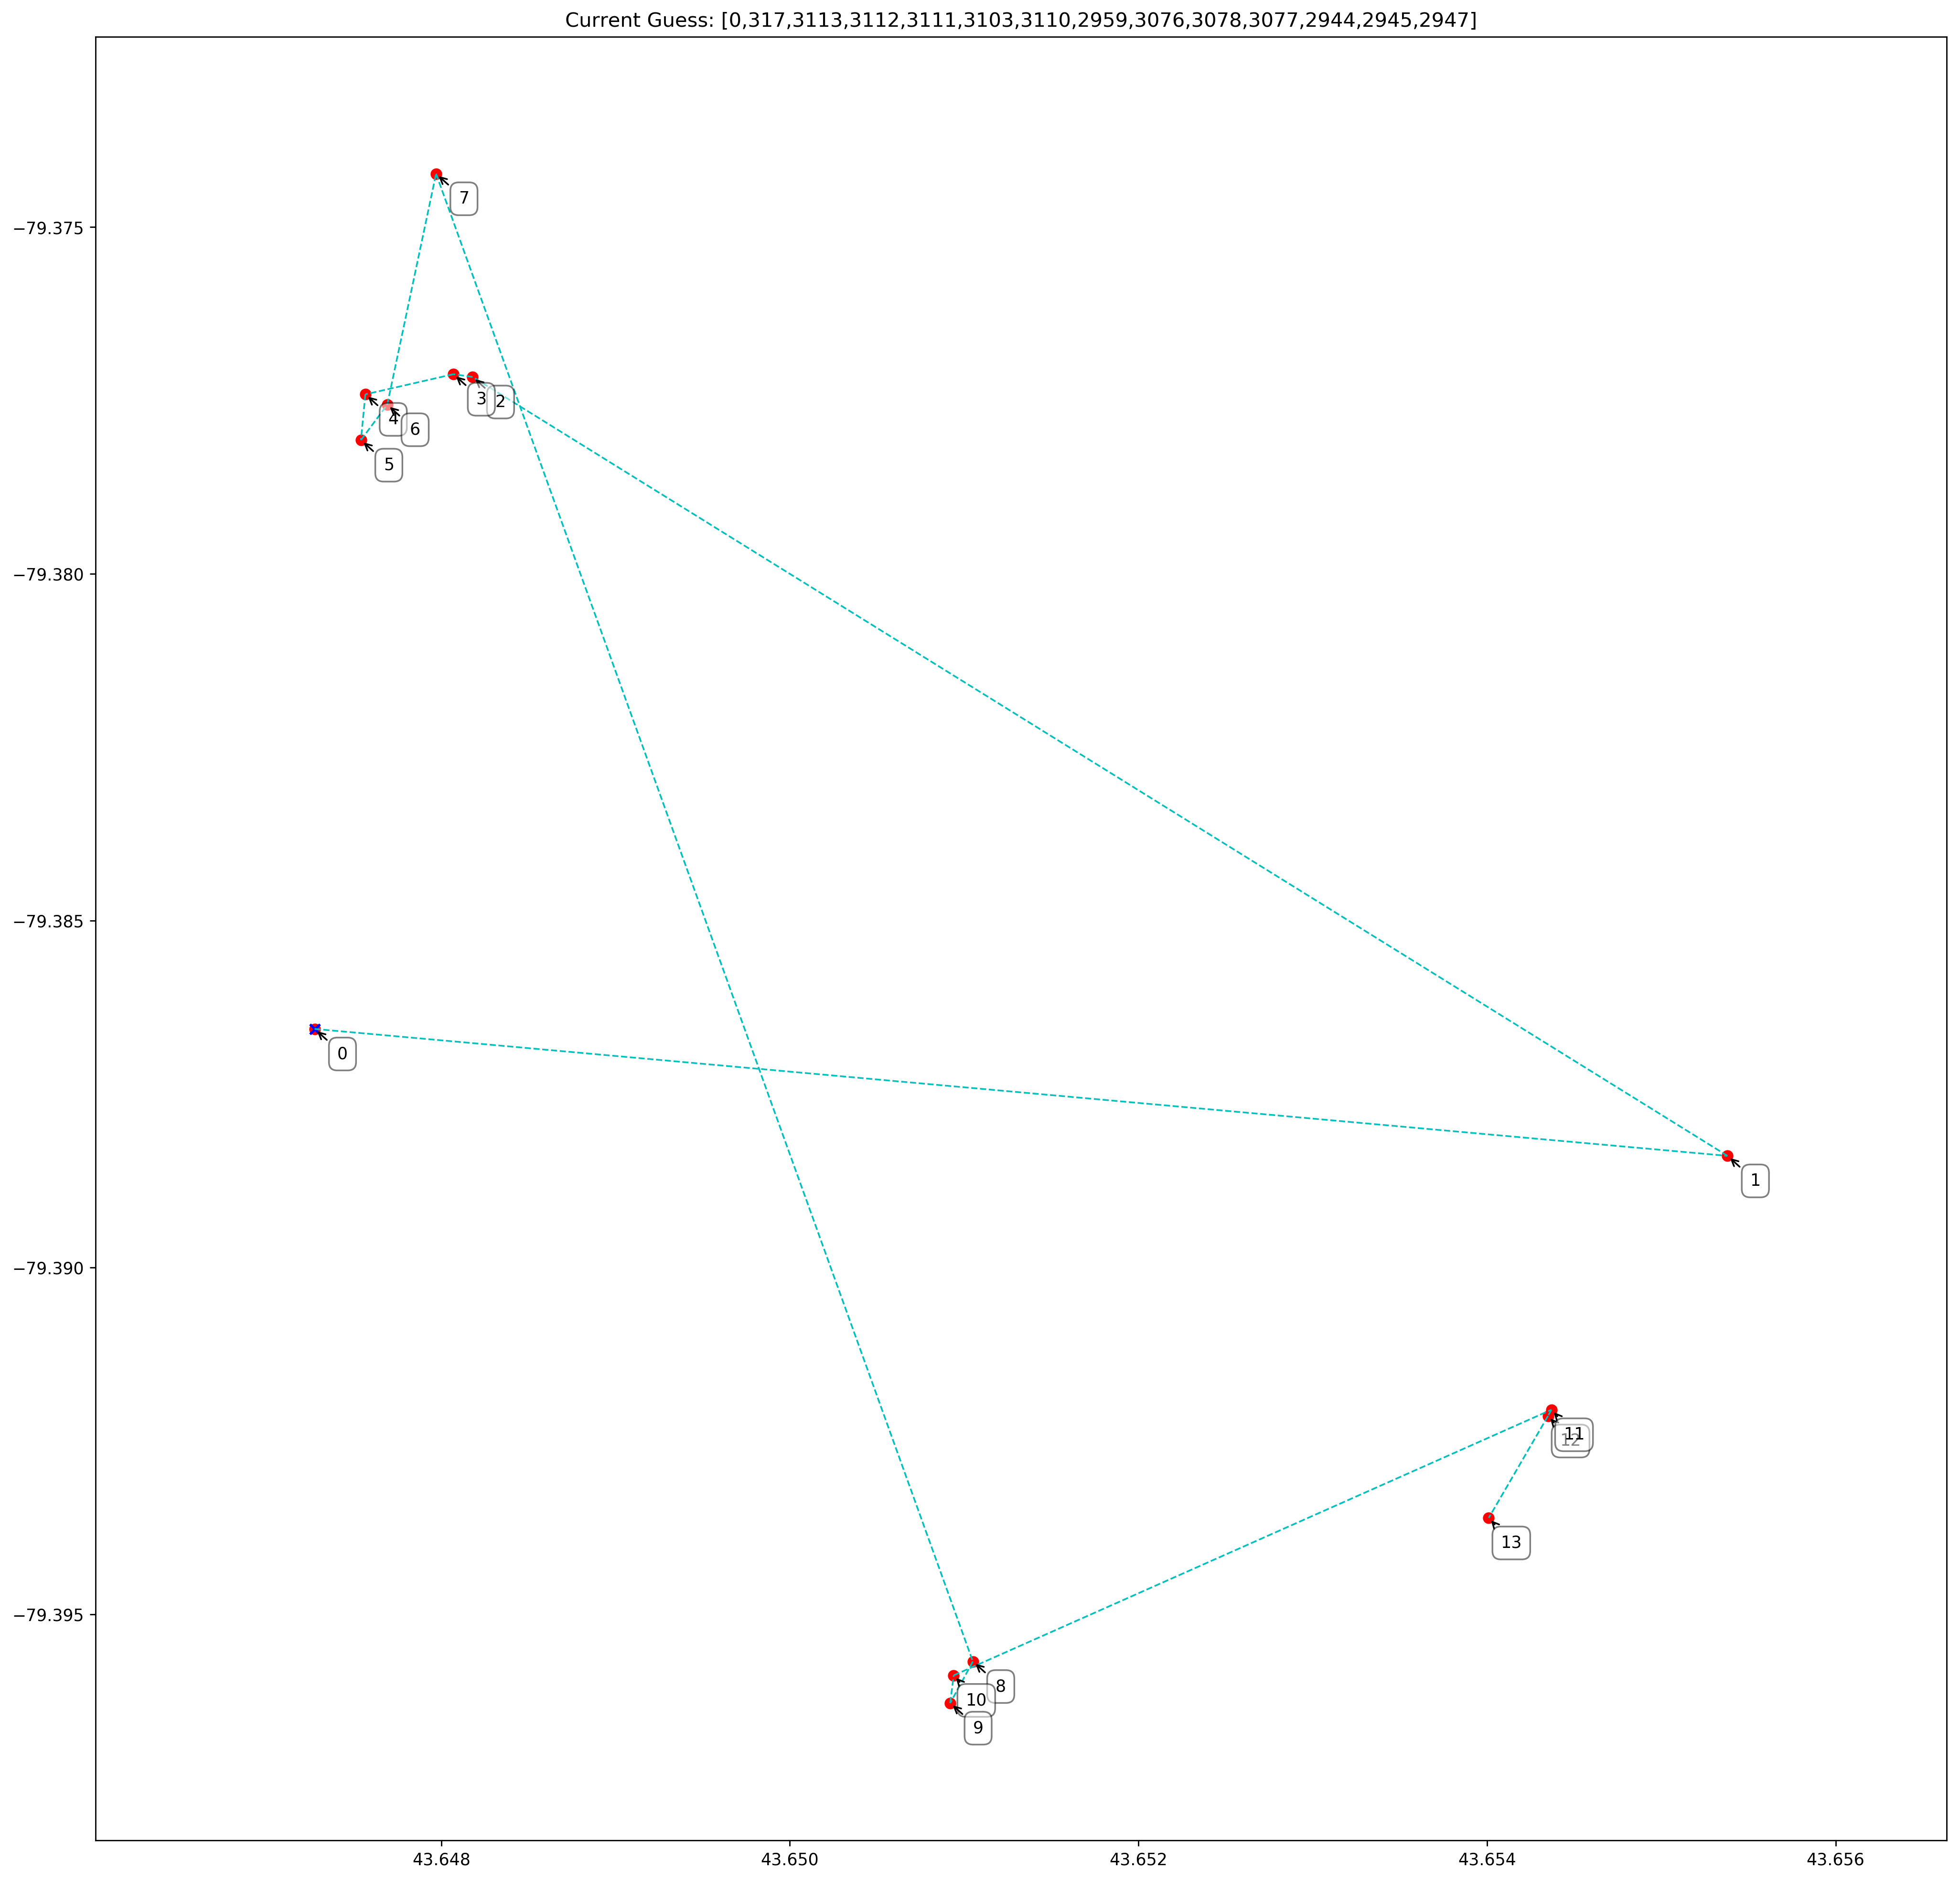

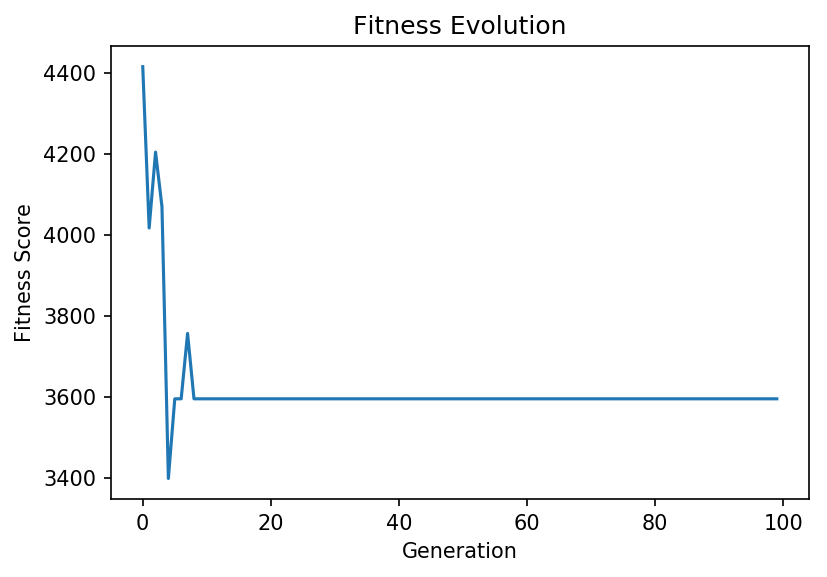

In [40]:
map_stops=find_optimal_route(df_filtered, starting_lat, starting_long,method='genetic')
map_stops

In [41]:
map_stops=find_optimal_route(df_filtered, starting_lat, starting_long, method='google')
map_stops

Total distance: 5612 miles

0
8
9
7
11
12
13
1
3
4
10
5
6
2
Route:

(43.647273, -79.38656) -> (43.65094, -79.39588) -> (43.65092, -79.39628) -> (43.65105, -79.39568) -> (43.65401, -79.39361) -> (43.65435, -79.39214) -> (43.65437, -79.39205) -> (43.65538, -79.38839) -> (43.64818, -79.37716) -> (43.64807, -79.37712) -> (43.64797, -79.37423) -> (43.6475644, -79.3774104) -> (43.64769, -79.37756) -> (43.6475389, -79.3780705) -> (43.647273, -79.38656)
